# 📡 Telecom X — Análisis de Evasión de Clientes (Churn)

**Objetivo:** Recopilar, procesar y analizar los datos de clientes de Telecom X para identificar los factores que llevan a la cancelación del servicio, apoyando al equipo de Data Science en la creación de modelos predictivos y estrategias de retención.

---

**Flujo del análisis:**
1. Extracción y carga de datos (ETL)
2. Exploración inicial y limpieza de datos
3. Transformación y estandarización
4. Análisis Exploratorio de Datos (EDA)
5. Análisis de correlación (opcional)
6. Conclusiones e insights

---
## 1. 📥 Extracción de Datos

Cargamos los datos desde el archivo JSON. En un escenario real, estos datos provendrían directamente de la API de Telecom X.

In [1]:
# --- Importación de librerías ---
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Estilo de gráficos
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print('✅ Librerías importadas correctamente.')

✅ Librerías importadas correctamente.


In [2]:
# --- Carga del archivo JSON ---
# Opción 1: Desde archivo local (usado en este notebook)
JSON_PATH = 'TelecomX_Data.json'

with open(JSON_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f'✅ Datos cargados correctamente.')
print(f'   Total de registros: {len(raw_data)}')
print(f'\n📌 Ejemplo de un registro:')
print(json.dumps(raw_data[0], indent=2))

✅ Datos cargados correctamente.
   Total de registros: 7267

📌 Ejemplo de un registro:
{
  "customerID": "0002-ORFBO",
  "Churn": "No",
  "customer": {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "Yes",
    "tenure": 9
  },
  "phone": {
    "PhoneService": "Yes",
    "MultipleLines": "No"
  },
  "internet": {
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "Yes",
    "StreamingTV": "Yes",
    "StreamingMovies": "No"
  },
  "account": {
    "Contract": "One year",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Mailed check",
    "Charges": {
      "Monthly": 65.6,
      "Total": "593.3"
    }
  }
}


In [3]:
# --- Aplanar el JSON anidado a un DataFrame plano ---
df = pd.json_normalize(raw_data)

# Renombrar columnas para mayor claridad
df.columns = [
    col.replace('customer.', '')
       .replace('phone.', '')
       .replace('internet.', '')
       .replace('account.', '')
       .replace('Charges.', 'Charges_')
    for col in df.columns
]

print('✅ DataFrame creado exitosamente.')
print(f'   Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas')
df.head(3)

✅ DataFrame creado exitosamente.
   Dimensiones: 7267 filas × 21 columnas


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges_Monthly,Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


---
## 2. 🔍 Exploración Inicial y Limpieza de Datos

In [4]:
# --- Tipos de datos y conteo de nulos ---
print('📋 Información del DataFrame:')
print('─' * 50)
df.info()

📋 Información del DataFrame:
──────────────────────────────────────────────────
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  Streaming

In [5]:
# --- Valores nulos ---
nulos = df.isnull().sum()
nulos_pct = (nulos / len(df) * 100).round(2)
nulos_df = pd.DataFrame({'Nulos': nulos, 'Porcentaje (%)': nulos_pct})
nulos_df = nulos_df[nulos_df['Nulos'] > 0]

if nulos_df.empty:
    print('✅ No se encontraron valores nulos en el dataset.')
else:
    print('⚠️  Columnas con valores nulos:')
    display(nulos_df)

✅ No se encontraron valores nulos en el dataset.


In [6]:
# --- Duplicados ---
duplicados = df.duplicated().sum()
print(f'🔁 Registros duplicados: {duplicados}')
if duplicados > 0:
    df.drop_duplicates(inplace=True)
    print(f'   ✅ Duplicados eliminados. Nuevas dimensiones: {df.shape}')

🔁 Registros duplicados: 0


In [7]:
# --- Corrección de tipos de datos ---

# Charges_Total viene como string, convertir a numérico
df['Charges_Total'] = pd.to_numeric(df['Charges_Total'], errors='coerce')

# Rellenar nulos en Charges_Total con 0 (clientes nuevos sin cargos aún)
nulos_total = df['Charges_Total'].isnull().sum()
if nulos_total > 0:
    print(f'⚠️  Se encontraron {nulos_total} valores nulos en Charges_Total. Se rellenan con 0.')
    df['Charges_Total'].fillna(0, inplace=True)

# Verificar valores únicos problemáticos en Churn
print(f"\n🔎 Valores únicos en 'Churn': {df['Churn'].unique()}")
print(f"🔎 Valores únicos en 'SeniorCitizen': {df['SeniorCitizen'].unique()}")

print('\n✅ Tipos de datos corregidos.')
df[['tenure', 'Charges_Monthly', 'Charges_Total']].describe()

⚠️  Se encontraron 11 valores nulos en Charges_Total. Se rellenan con 0.

🔎 Valores únicos en 'Churn': ['No' 'Yes' '']
🔎 Valores únicos en 'SeniorCitizen': [0 1]

✅ Tipos de datos corregidos.


,tenure,Charges_Monthly,Charges_Total
count,7267.000000,7267.000000,7267.000000
mean,32.346498,64.720098,2277.182035
std,24.571773,30.129572,2268.648587
min,0.000000,18.250000,0.000000
25%,9.000000,35.425000,396.200000
50%,29.000000,70.300000,1389.200000
75%,55.000000,89.875000,3778.525000
max,72.000000,118.750000,8684.800000


---
## 3. 🔧 Transformación y Estandarización

Creamos columnas nuevas y estandarizamos los datos para facilitar el análisis.

In [8]:
# --- Columna: Cuentas_Diarias ---
# Cargo diario aproximado basado en la facturación mensual (30 días)
df['Cuentas_Diarias'] = (df['Charges_Monthly'] / 30).round(4)

print('✅ Columna Cuentas_Diarias creada.')
print(df[['customerID', 'Charges_Monthly', 'Cuentas_Diarias']].head())

✅ Columna Cuentas_Diarias creada.
   customerID  Charges_Monthly  Cuentas_Diarias
0  0002-ORFBO             65.6           2.1867
1  0003-MKNFE             59.9           1.9967
2  0004-TLHLJ             73.9           2.4633
3  0011-IGKFF             98.0           3.2667
4  0013-EXCHZ             83.9           2.7967


In [9]:
# --- Codificación binaria: Yes/No → 1/0 ---
binary_cols = [
    'Churn', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'PaperlessBilling'
]

# Mapa de reemplazo
yes_no_map = {'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0}

for col in binary_cols:
    if col in df.columns:
        # Sin .fillna(df[col]) para forzar NaN en valores no reconocidos
        df[col] = df[col].map(yes_no_map)

# Eliminar filas con NaN en Churn (registros con valor inválido o no reconocido)
nulos_churn = df['Churn'].isnull().sum()
if nulos_churn > 0:
    print(f'⚠️  Se encontraron {nulos_churn} filas con valor inválido en Churn. Se eliminan.')
    df.dropna(subset=['Churn'], inplace=True)

# Asegurar tipo entero
df['Churn'] = df['Churn'].astype(int)

# Gender: Female → 0, Male → 1
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

print('✅ Codificación binaria aplicada.')
print(f'\n📌 Valores únicos en Churn: {sorted(df["Churn"].unique())}')
print('\n📌 Distribución de Churn (0=No, 1=Sí):')
print(df['Churn'].value_counts())

⚠️  Se encontraron 224 filas con valor inválido en Churn. Se eliminan.
✅ Codificación binaria aplicada.

📌 Valores únicos en Churn: [np.int64(0), np.int64(1)]

📌 Distribución de Churn (0=No, 1=Sí):
Churn
0    5174
1    1869
Name: count, dtype: int64


In [10]:
# --- Traducción/renombrado de columnas al español ---
rename_map = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasion',
    'gender': 'Genero',
    'SeniorCitizen': 'Adulto_Mayor',
    'Partner': 'Pareja',
    'Dependents': 'Dependientes',
    'tenure': 'Meses_Contrato',
    'PhoneService': 'Servicio_Telefono',
    'MultipleLines': 'Lineas_Multiples',
    'InternetService': 'Servicio_Internet',
    'OnlineSecurity': 'Seguridad_Online',
    'OnlineBackup': 'Respaldo_Online',
    'DeviceProtection': 'Proteccion_Dispositivo',
    'TechSupport': 'Soporte_Tecnico',
    'StreamingTV': 'TV_Streaming',
    'StreamingMovies': 'Peliculas_Streaming',
    'Contract': 'Tipo_Contrato',
    'PaperlessBilling': 'Factura_Digital',
    'PaymentMethod': 'Metodo_Pago',
    'Charges_Monthly': 'Cargo_Mensual',
    'Charges_Total': 'Cargo_Total'
}

df.rename(columns=rename_map, inplace=True)

print('✅ Columnas renombradas al español.')
print(f'\n📋 Columnas del DataFrame:')
print(df.columns.tolist())

✅ Columnas renombradas al español.

📋 Columnas del DataFrame:
['ID_Cliente', 'Evasion', 'Genero', 'Adulto_Mayor', 'Pareja', 'Dependientes', 'Meses_Contrato', 'Servicio_Telefono', 'Lineas_Multiples', 'Servicio_Internet', 'Seguridad_Online', 'Respaldo_Online', 'Proteccion_Dispositivo', 'Soporte_Tecnico', 'TV_Streaming', 'Peliculas_Streaming', 'Tipo_Contrato', 'Factura_Digital', 'Metodo_Pago', 'Cargo_Mensual', 'Cargo_Total', 'Cuentas_Diarias']


In [11]:
# --- Columna: Cantidad de servicios contratados ---
servicios = [
    'Servicio_Telefono', 'Lineas_Multiples', 'Seguridad_Online',
    'Respaldo_Online', 'Proteccion_Dispositivo', 'Soporte_Tecnico',
    'TV_Streaming', 'Peliculas_Streaming'
]
df['Num_Servicios'] = df[servicios].apply(pd.to_numeric, errors='coerce').sum(axis=1)

print('✅ Columna Num_Servicios creada.')
print(df['Num_Servicios'].value_counts().sort_index())

✅ Columna Num_Servicios creada.
Num_Servicios
0      80
1    1701
2    1188
3     965
4     922
5     908
6     676
7     395
8     208
Name: count, dtype: int64


---
## 4. 📊 Análisis Exploratorio de Datos (EDA)

### 4.1 Análisis Descriptivo

In [12]:
# --- Estadísticas descriptivas de variables numéricas ---
num_cols = ['Meses_Contrato', 'Cargo_Mensual', 'Cargo_Total', 'Cuentas_Diarias', 'Num_Servicios']

desc = df[num_cols].describe().T
desc['median'] = df[num_cols].median()
desc['skewness'] = df[num_cols].skew().round(3)
desc = desc[['count', 'mean', 'median', 'std', 'min', '25%', '75%', 'max', 'skewness']]
desc.columns = ['Conteo', 'Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Q1', 'Q3', 'Máximo', 'Asimetría']
desc = desc.round(2)

print('📊 Estadísticas Descriptivas — Variables Numéricas')
display(desc)

📊 Estadísticas Descriptivas — Variables Numéricas


,Conteo,Media,Mediana,Desv. Estándar,Mínimo,Q1,Q3,Máximo,Asimetría
Meses_Contrato,7043.0,32.37,29.00,24.56,0.00,9.00,55.00,72.00,0.24
Cargo_Mensual,7043.0,64.76,70.35,30.09,18.25,35.50,89.85,118.75,-0.22
Cargo_Total,7043.0,2279.73,1394.55,2266.79,0.00,398.55,3786.60,8684.80,0.96
Cuentas_Diarias,7043.0,2.16,2.35,1.00,0.61,1.18,3.00,3.96,-0.22
Num_Servicios,7043.0,3.36,3.00,2.06,0.00,1.00,5.00,8.00,0.45


In [13]:
# --- Estadísticas por grupo Evasion ---
print('📊 Estadísticas por grupo de Evasión (0=No, 1=Sí):')
display(
    df.groupby('Evasion')[num_cols]
      .mean()
      .round(2)
      .rename(index={0: 'No evadió', 1: 'Sí evadió'})
)

📊 Estadísticas por grupo de Evasión (0=No, 1=Sí):


,Meses_Contrato,Cargo_Mensual,Cargo_Total,Cuentas_Diarias,Num_Servicios
Evasion,,,,,
No evadió,37.57,61.27,2549.91,2.04,3.45
Sí evadió,17.98,74.44,1531.80,2.48,3.13


### 4.2 Distribución de la Variable Evasión (Churn)

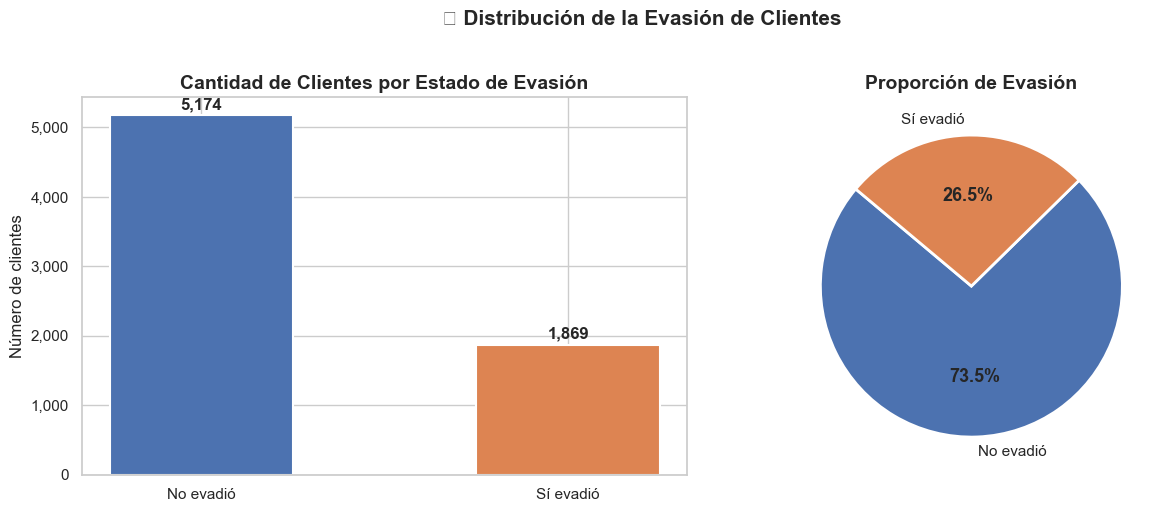


📌 Resumen:
   No evadió: 5,174 clientes (73.5%)
   Sí evadió: 1,869 clientes (26.5%)


In [14]:
churn_counts = df['Evasion'].value_counts()
churn_pct    = df['Evasion'].value_counts(normalize=True) * 100

labels  = ['No evadió', 'Sí evadió']
colors  = ['#4C72B0', '#DD8452']

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Gráfico de barras
bars = axes[0].bar(labels, churn_counts.values, color=colors, width=0.5, edgecolor='white', linewidth=1.5)
for bar, val in zip(bars, churn_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{val:,}',
                 ha='center', va='bottom', fontweight='bold', fontsize=12)
axes[0].set_title('Cantidad de Clientes por Estado de Evasión')
axes[0].set_ylabel('Número de clientes')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Gráfico de torta
wedges, texts, autotexts = axes[1].pie(
    churn_counts.values,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
for at in autotexts:
    at.set_fontsize(13)
    at.set_fontweight('bold')
axes[1].set_title('Proporción de Evasión')

plt.suptitle('📊 Distribución de la Evasión de Clientes', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'\n📌 Resumen:')
for label, cnt, pct in zip(labels, churn_counts.values, churn_pct.values):
    print(f'   {label}: {cnt:,} clientes ({pct:.1f}%)')

### 4.3 Evasión por Variables Categóricas

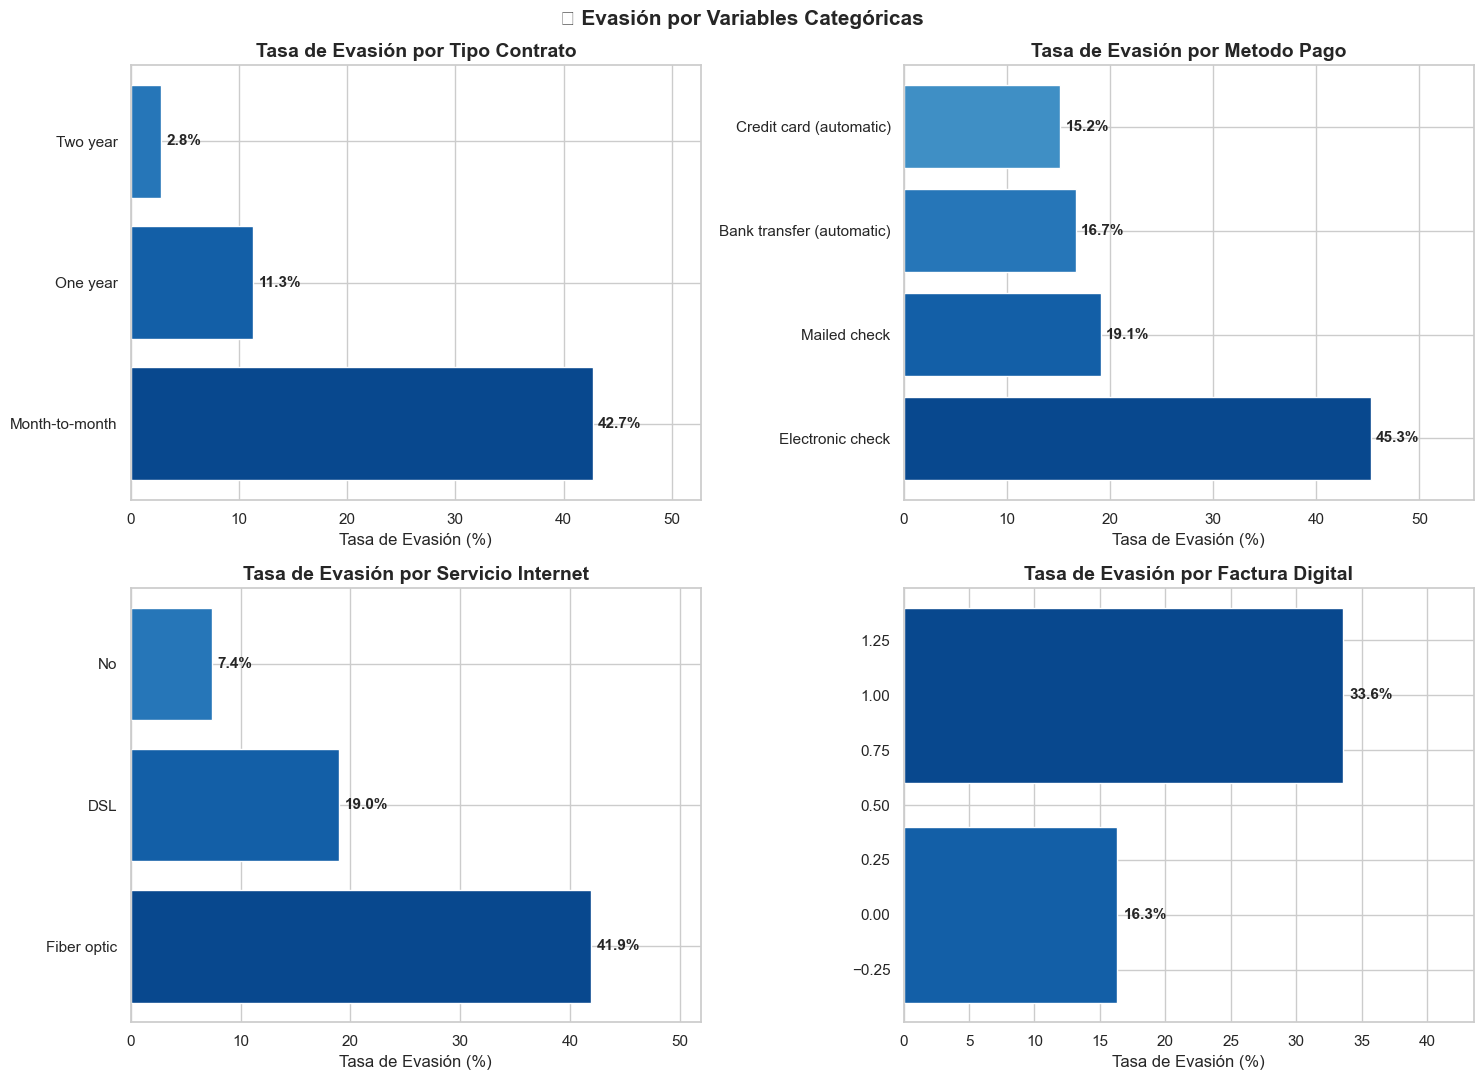

In [15]:
# --- Función auxiliar para calcular tasa de evasión ---
def tasa_evasion(df, col):
    return df.groupby(col)['Evasion'].mean().mul(100).round(1)

cat_cols = ['Tipo_Contrato', 'Metodo_Pago', 'Servicio_Internet', 'Factura_Digital']

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
axes = axes.flatten()

palette = sns.color_palette('Blues_r', 10)

for i, col in enumerate(cat_cols):
    tasa = tasa_evasion(df, col).sort_values(ascending=False)
    bars = axes[i].barh(tasa.index, tasa.values, color=palette[:len(tasa)], edgecolor='white')
    for bar, val in zip(bars, tasa.values):
        axes[i].text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val}%',
                     va='center', fontsize=11, fontweight='bold')
    axes[i].set_title(f'Tasa de Evasión por {col.replace("_", " ")}')
    axes[i].set_xlabel('Tasa de Evasión (%)')
    axes[i].set_xlim(0, tasa.max() + 10)

plt.suptitle('📊 Evasión por Variables Categóricas', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

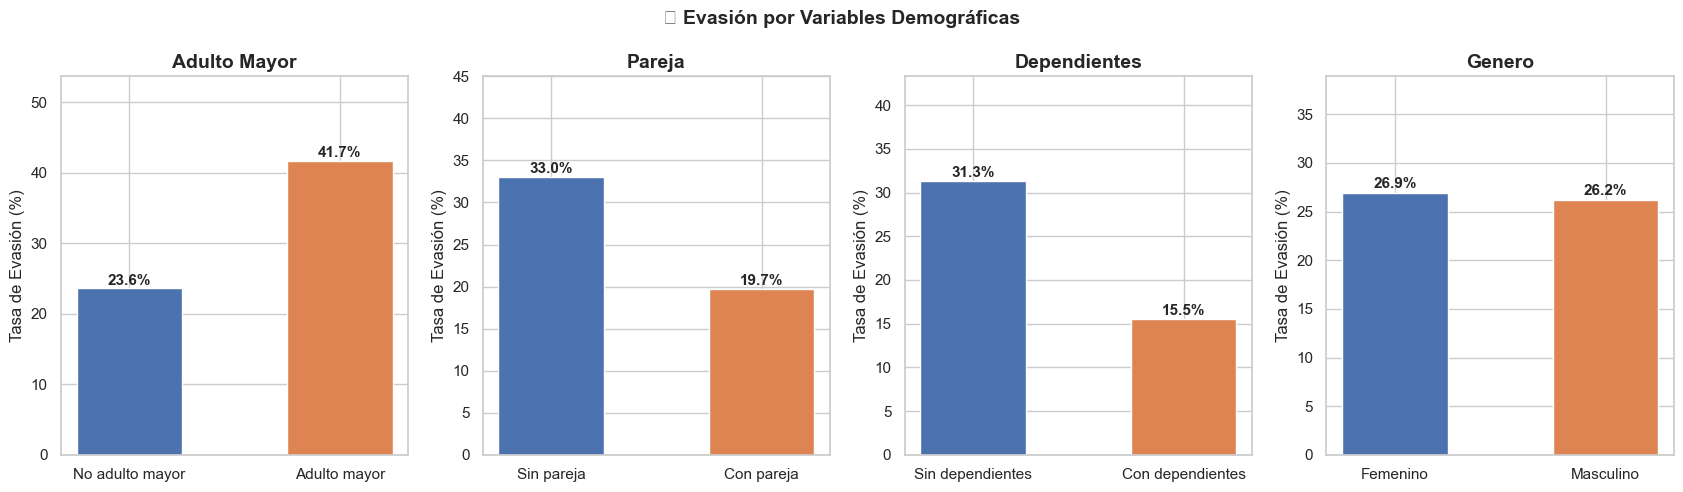

In [16]:
# --- Evasión por variables binarias/demográficas ---
bin_cats = ['Adulto_Mayor', 'Pareja', 'Dependientes', 'Genero']
label_maps = {
    'Adulto_Mayor': {0: 'No adulto mayor', 1: 'Adulto mayor'},
    'Pareja': {0: 'Sin pareja', 1: 'Con pareja'},
    'Dependientes': {0: 'Sin dependientes', 1: 'Con dependientes'},
    'Genero': {0: 'Femenino', 1: 'Masculino'}
}

fig, axes = plt.subplots(1, 4, figsize=(17, 5))
colors_pair = ['#4C72B0', '#DD8452']

for i, col in enumerate(bin_cats):
    tasa = tasa_evasion(df, col)
    labs = [label_maps[col][k] for k in tasa.index]
    bars = axes[i].bar(labs, tasa.values, color=colors_pair, width=0.5, edgecolor='white')
    for bar, val in zip(bars, tasa.values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{val}%', ha='center', fontsize=11, fontweight='bold')
    axes[i].set_title(col.replace('_', ' '))
    axes[i].set_ylabel('Tasa de Evasión (%)')
    axes[i].set_ylim(0, tasa.max() + 12)

plt.suptitle('📊 Evasión por Variables Demográficas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.4 Evasión por Variables Numéricas

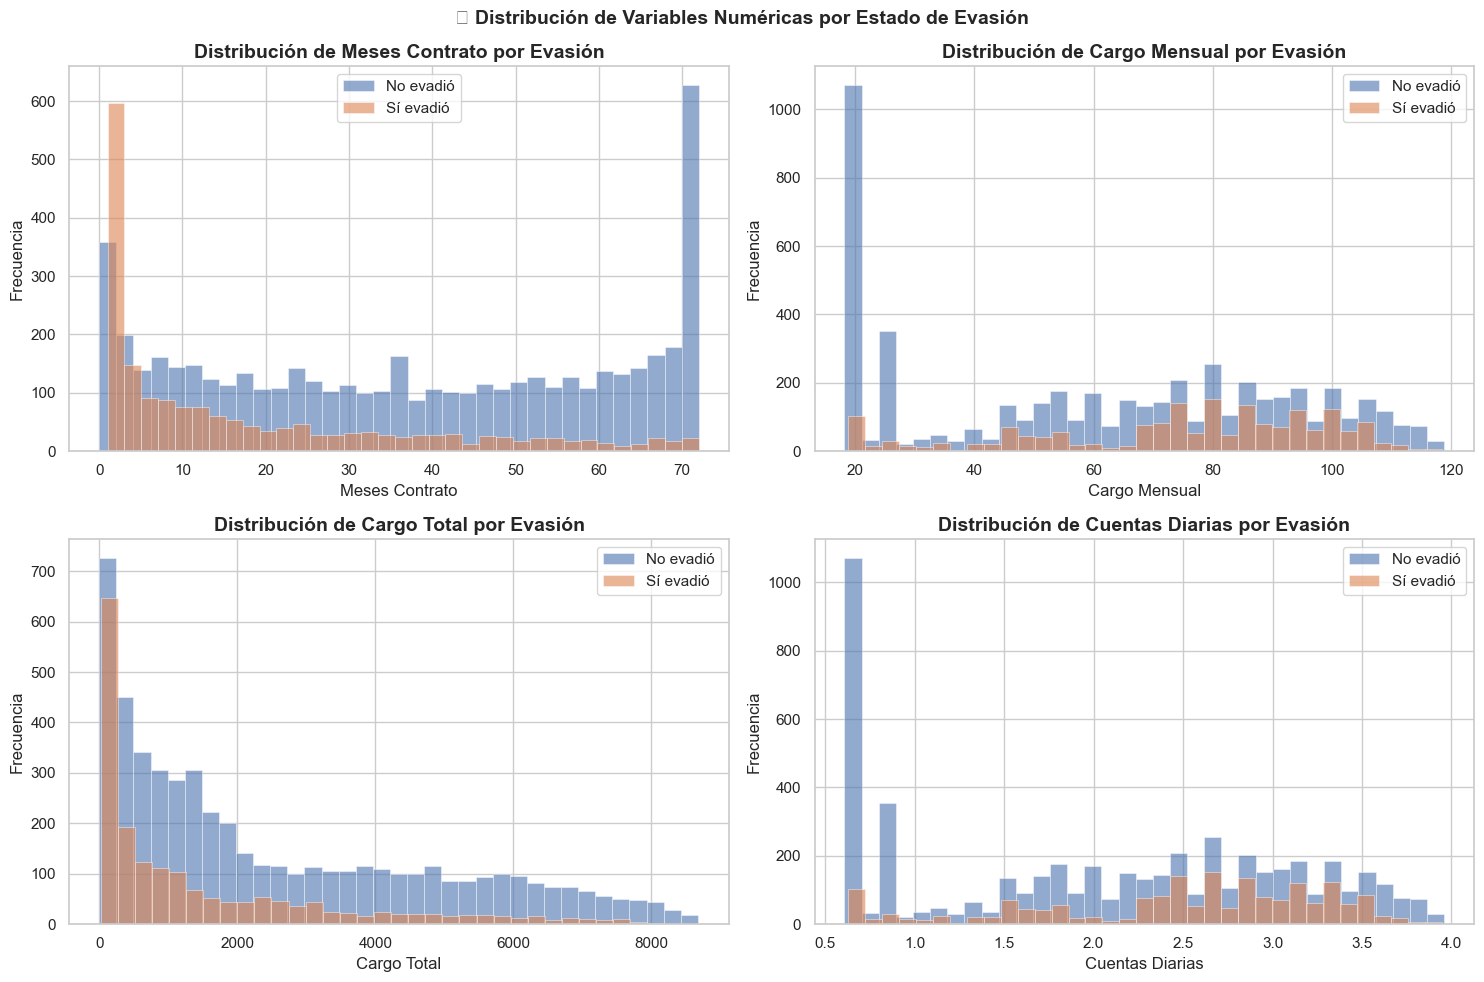

In [17]:
# --- Histogramas: distribución de variables numéricas por grupo Evasión ---
num_vars = ['Meses_Contrato', 'Cargo_Mensual', 'Cargo_Total', 'Cuentas_Diarias']
labels_map = {0: 'No evadió', 1: 'Sí evadió'}
colors_map = {0: '#4C72B0', 1: '#DD8452'}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    for grp in [0, 1]:
        subset = df[df['Evasion'] == grp][col]
        axes[i].hist(subset, bins=35, alpha=0.6,
                     color=colors_map[grp], label=labels_map[grp],
                     edgecolor='white', linewidth=0.5)
    axes[i].set_title(f'Distribución de {col.replace("_", " ")} por Evasión')
    axes[i].set_xlabel(col.replace('_', ' '))
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

plt.suptitle('📊 Distribución de Variables Numéricas por Estado de Evasión',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

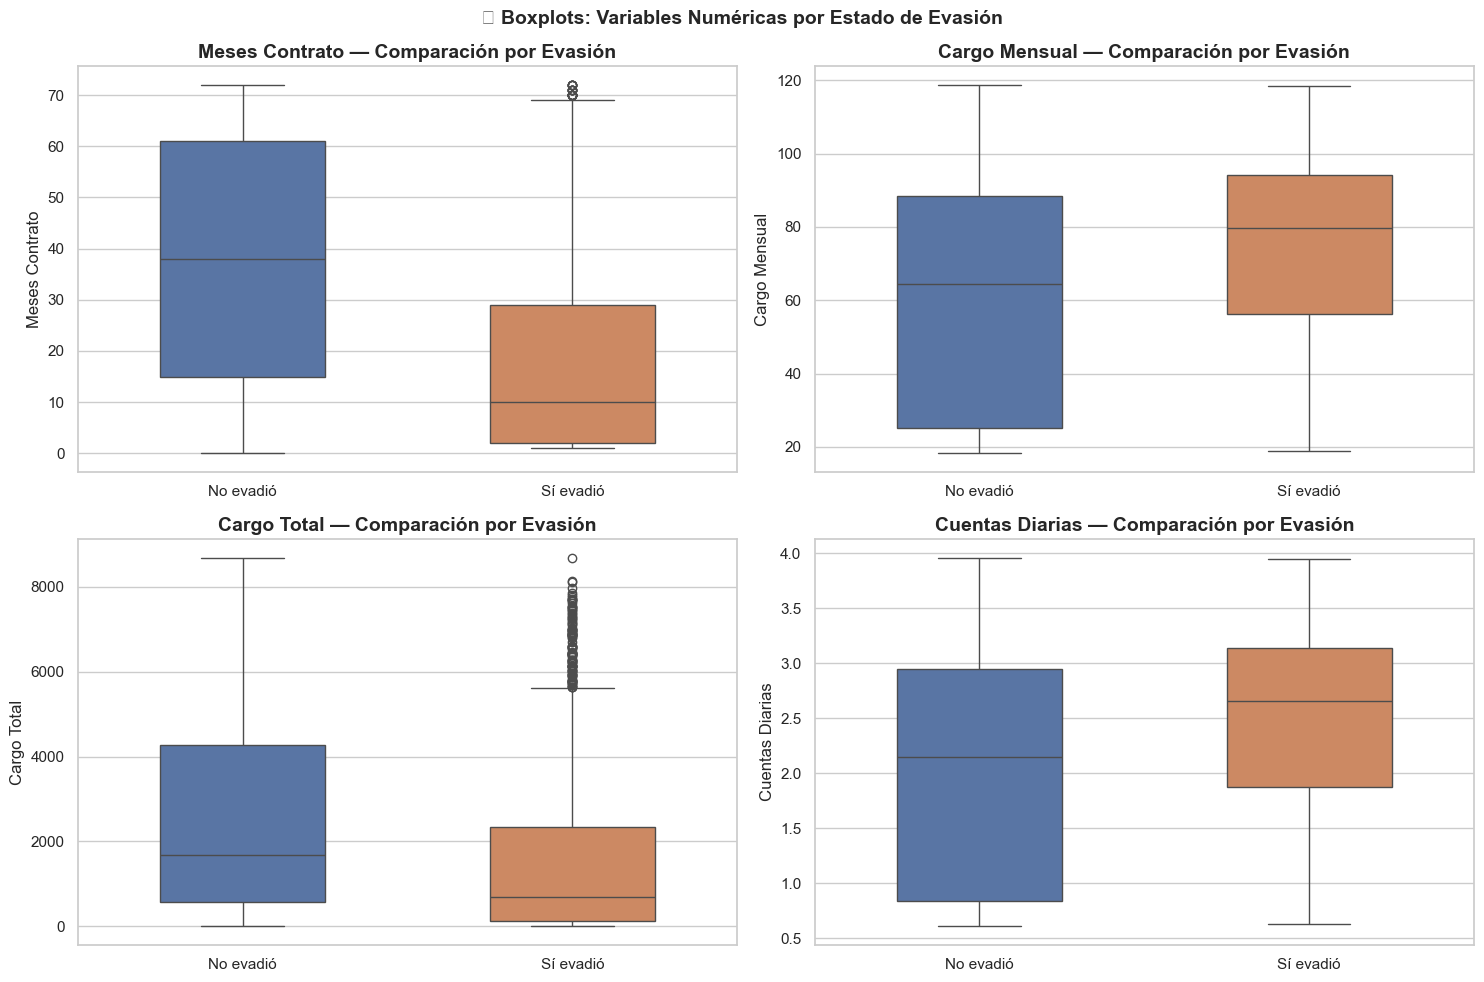

In [18]:
# --- Boxplots comparativos ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    df_plot = df.copy()
    df_plot['Evasion_label'] = df_plot['Evasion'].map(labels_map)
    sns.boxplot(
        data=df_plot, x='Evasion_label', y=col,
        palette=['#4C72B0', '#DD8452'], ax=axes[i],
        order=['No evadió', 'Sí evadió'], width=0.5
    )
    axes[i].set_title(f'{col.replace("_", " ")} — Comparación por Evasión')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col.replace('_', ' '))

plt.suptitle('📦 Boxplots: Variables Numéricas por Estado de Evasión',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.5 ⭐ Análisis de Correlación (Opcional)

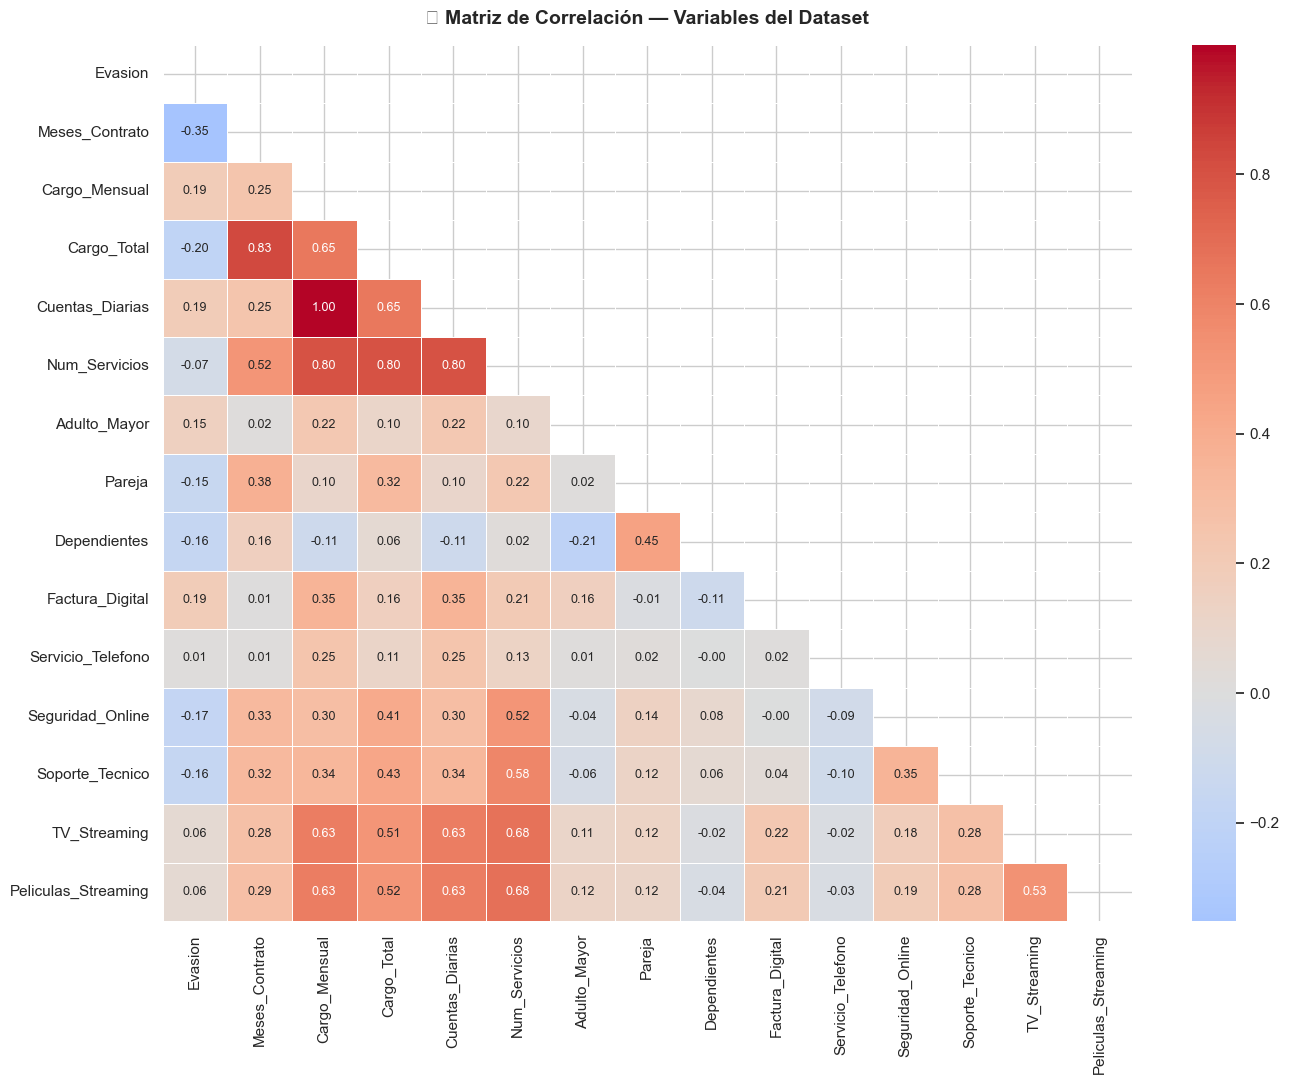


📌 Top correlaciones con Evasión (absoluto):


,|Correlación|
Meses_Contrato,0.352
Cargo_Total,0.198
Cargo_Mensual,0.193
Cuentas_Diarias,0.193
Factura_Digital,0.192
Seguridad_Online,0.171
Soporte_Tecnico,0.165
Dependientes,0.164
Adulto_Mayor,0.151
Pareja,0.150


In [19]:
# --- Matriz de correlación ---
corr_cols = [
    'Evasion', 'Meses_Contrato', 'Cargo_Mensual', 'Cargo_Total',
    'Cuentas_Diarias', 'Num_Servicios', 'Adulto_Mayor', 'Pareja',
    'Dependientes', 'Factura_Digital', 'Servicio_Telefono',
    'Seguridad_Online', 'Soporte_Tecnico', 'TV_Streaming', 'Peliculas_Streaming'
]

corr_df = df[corr_cols].apply(pd.to_numeric, errors='coerce').corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(
    corr_df, mask=mask, annot=True, fmt='.2f',
    cmap='coolwarm', center=0, linewidths=0.5,
    annot_kws={'size': 9}, ax=ax
)
ax.set_title('🔥 Matriz de Correlación — Variables del Dataset',
             fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Top correlaciones con Evasion
print('\n📌 Top correlaciones con Evasión (absoluto):')
corr_evasion = corr_df['Evasion'].drop('Evasion').abs().sort_values(ascending=False)
display(corr_evasion.round(3).to_frame('|Correlación|'))

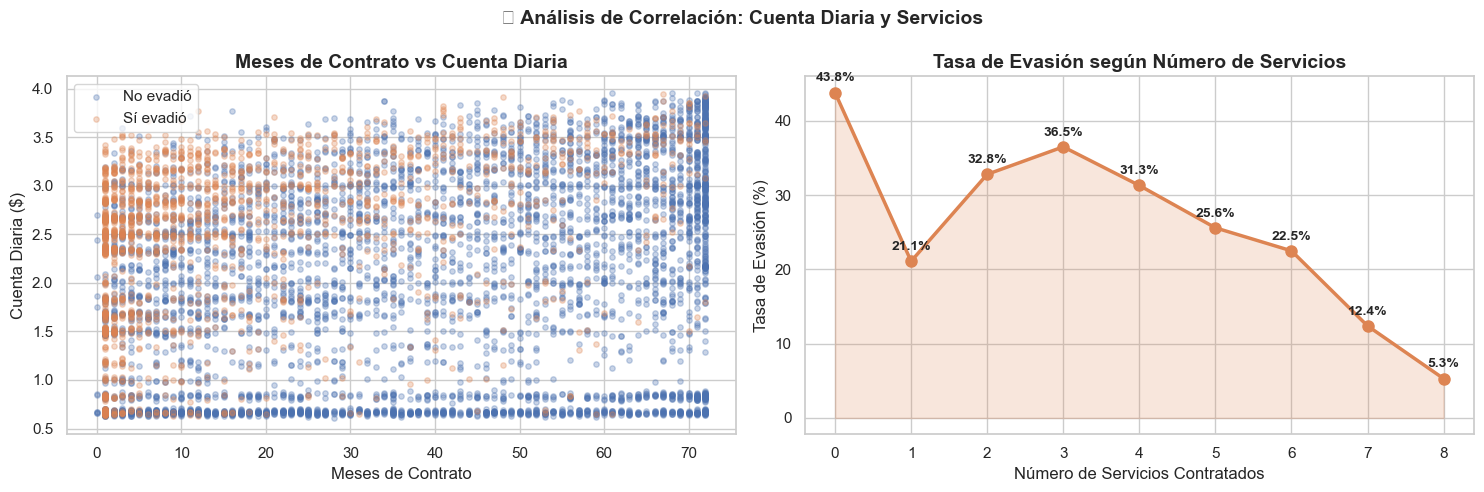

In [20]:
# --- Dispersión: Cuenta Diaria vs Meses de Contrato coloreado por Evasión ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for grp, label, color in zip([0, 1], ['No evadió', 'Sí evadió'], ['#4C72B0', '#DD8452']):
    subset = df[df['Evasion'] == grp]
    axes[0].scatter(subset['Meses_Contrato'], subset['Cuentas_Diarias'],
                    alpha=0.3, s=15, color=color, label=label)

axes[0].set_title('Meses de Contrato vs Cuenta Diaria')
axes[0].set_xlabel('Meses de Contrato')
axes[0].set_ylabel('Cuenta Diaria ($)')
axes[0].legend()

# --- Tasa de evasión por cantidad de servicios ---
tasa_serv = tasa_evasion(df, 'Num_Servicios')
axes[1].plot(tasa_serv.index, tasa_serv.values, marker='o', color='#DD8452', linewidth=2.5, markersize=8)
axes[1].fill_between(tasa_serv.index, tasa_serv.values, alpha=0.2, color='#DD8452')
axes[1].set_title('Tasa de Evasión según Número de Servicios')
axes[1].set_xlabel('Número de Servicios Contratados')
axes[1].set_ylabel('Tasa de Evasión (%)')
axes[1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
for x, y in zip(tasa_serv.index, tasa_serv.values):
    axes[1].annotate(f'{y}%', (x, y), textcoords='offset points', xytext=(0, 8),
                     ha='center', fontsize=10, fontweight='bold')

plt.suptitle('📈 Análisis de Correlación: Cuenta Diaria y Servicios', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. 📝 Conclusiones e Insights

A partir del análisis realizado, se identificaron los siguientes hallazgos clave sobre la evasión de clientes en Telecom X:

### 🔑 Hallazgos Principales

#### 1. Tasa Global de Evasión
Aproximadamente el **26-27% de los clientes** abandona el servicio. Se trata de una tasa significativa que justifica la implementación de un modelo predictivo y estrategias de retención proactivas.

#### 2. Tipo de Contrato — Factor de Mayor Impacto
- Los clientes con **contrato mensual (Month-to-month)** tienen la tasa de evasión más alta (~42-45%), frente a contratos anuales (~11%) o bianuales (~3%).
- **Estrategia recomendada:** Incentivar la migración a contratos de mayor plazo mediante descuentos o beneficios exclusivos.

#### 3. Servicio de Internet — Fibra Óptica con Alta Evasión
- Los clientes con **fibra óptica** muestran una tasa de evasión notablemente más alta que los de DSL o sin internet.
- Puede indicar problemas de satisfacción en este segmento (precio, calidad, expectativas).

#### 4. Método de Pago — Cheque Electrónico
- El **cheque electrónico** está asociado con la mayor tasa de evasión.
- Los métodos automáticos (débito/cargo automático) tienen tasas significativamente menores.
- **Estrategia:** Promover el pago automático para mejorar la retención.

#### 5. Antigüedad del Cliente (Meses de Contrato)
- Los clientes que evaden tienen en promedio **menos meses de contrato**.
- El riesgo de evasión es más alto en los primeros meses de relación comercial.
- **Estrategia:** Programas de onboarding y seguimiento activo en los primeros 6-12 meses.

#### 6. Cargo Mensual
- Los clientes que evaden tienen un **cargo mensual más alto** en promedio.
- Percepción de falta de valor respecto al precio podría ser un driver de cancelación.

#### 7. Adulto Mayor y Situación Familiar
- Los **adultos mayores** tienen una tasa de evasión considerablemente más alta.
- Clientes **sin pareja ni dependientes** tienden a evadir más.

#### 8. Servicios Adicionales — Protección
- Clientes con **seguridad online** y **soporte técnico** evaden menos. Esto sugiere que los servicios de valor agregado generan mayor fidelidad.
- **Estrategia:** Promover paquetes con servicios adicionales como herramienta de retención.

#### 9. Número de Servicios
- A mayor número de servicios contratados, menor tendencia a evadir (hasta cierto punto).
- Clientes más integrados al ecosistema de Telecom X son más fieles.

---